In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importing needed Libraries and Data

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac

In [ ]:
import tensorflow as tf
# If GPUs are enabled-- to limit memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteESGCV8/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteESGCV8/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()['label']

2


# 2. Viz Data and Build Dataset

In [ ]:
import numpy as np
# Iterator to loop over through each data points
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting random sample data out of the pipeline- to visualize it 
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

In [ ]:
np.squeeze(dataiterator.next()['image']).shape # Converts 28*28*1 into 28*28

(28, 28)

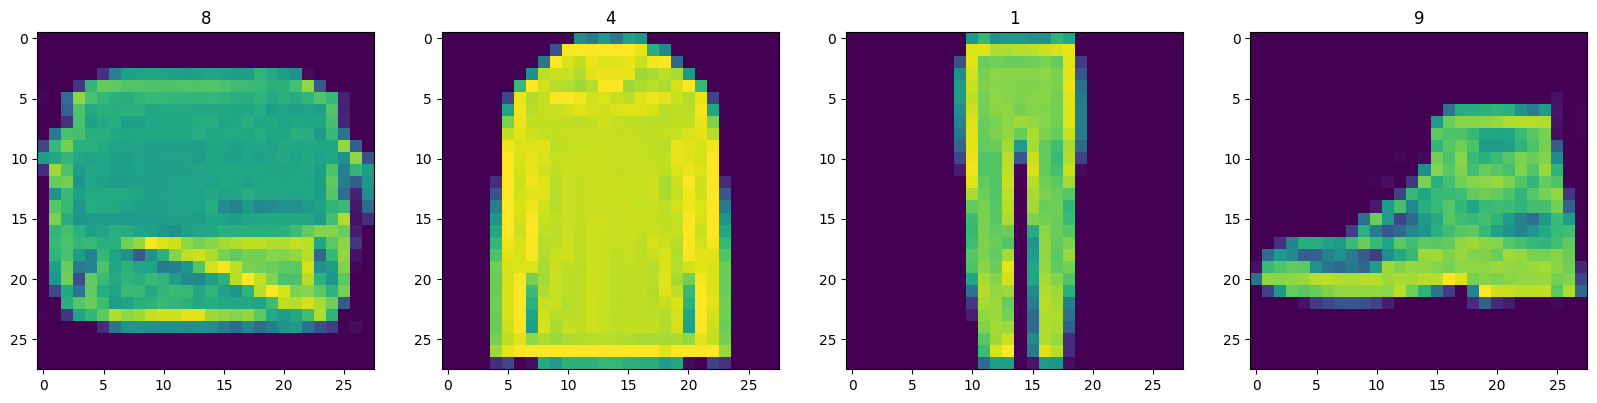

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop and get 4 images 
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [ ]:
# Scale and return images -- for faster training of the model
def scale_images(data): 
    image = data['image']
    return image / 255
# If we are using any cGAN, then we may need the labels also

# We could apply data augmentation also --if needed for other models

In [ ]:
''' Creating a data pipeline--- Common for any tensorflow model 
    1.map 2.cache 3.shuffle 4.batch 5.prefetch '''

# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

'''prefetch() --While the model is busy processing one batch of data, the next batch is being fetched and prepared in the background'''

'prefetch() --While the model is busy processing one batch of data, the next batch is being fetched and prepared in the background'

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build Neural Network

3.1 Import Modelling Components

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


3.2 Build Generator

In [ ]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshape it to 7x7x128
    # Beginning of a generated image
    model.add(Dense(7*7*128, input_dim=128))  # input_dim -- controls generation of image ; 7*7 -- gives shape
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))   # Finally we have to convert 7*7*128 into 28*28*1
    
    # Upsampling block 1 
    model.add(UpSampling2D())   #14*14*128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())   #28*28*128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model 

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))   # 4--images ; 128-- random values
img.shape

1/1 [==============================] - 8s 8s/step


(4, 28, 28, 1)

1/1 [==============================] - 0s 21ms/step


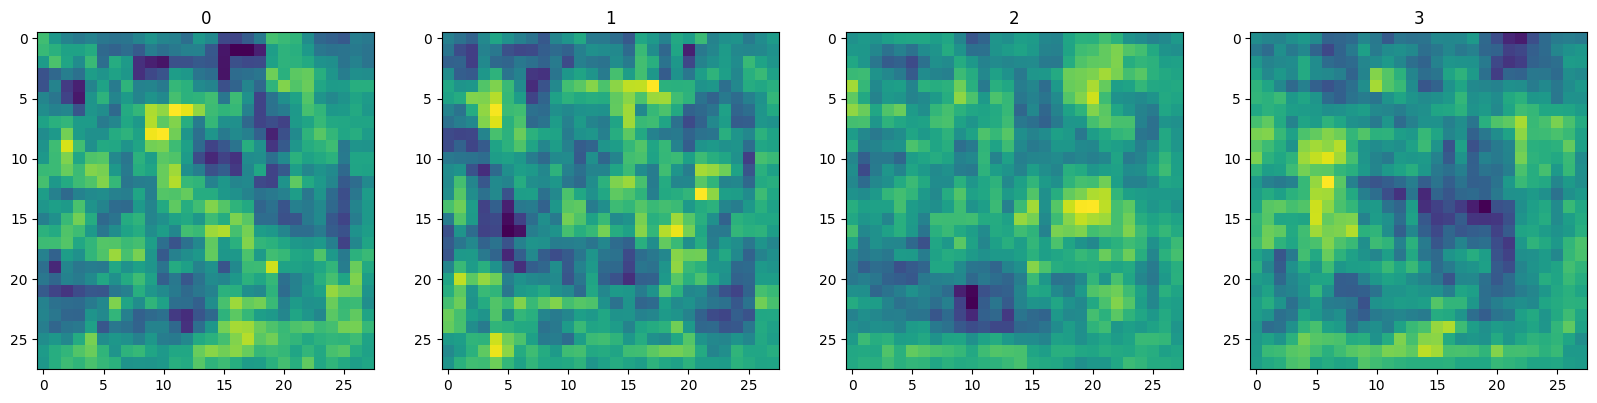

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images 
for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

3.3 Build Discriminator

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))    # need not mention input_shape except for the first layer
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))     # Fake -1; Real -0
    
    return model 

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))   # 4--images ; 128-- random values
img.shape

1/1 [==============================] - 0s 22ms/step


(4, 28, 28, 1)

In [ ]:
img = img[0]

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 189ms/step


array([[0.49416286]], dtype=float32)

# 4. Construct Training Loop

4.1 Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [ ]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[-9.85246837e-01],
        [-2.56640494e-01],
        [-5.16817987e-01],
        [-1.21611750e+00],
        [ 6.86758280e-01],
        [-8.83379206e-02],
        [-1.43935239e+00],
        [ 1.93405437e+00],
        [ 2.34740570e-01],
        [ 1.00350666e+00],
        [-1.77894123e-02],
        [-1.06256366e+00],
        [ 5.57596922e-01],
        [-1.34238863e+00],
        [-2.49511766e+00],
        [-1.98904383e+00],
        [ 7.42111325e-01],
        [ 4.29683596e-01],
        [-1.30219758e+00],
        [ 7.53716886e-01],
        [ 7.90542543e-01],
        [-1.02237189e+00],
        [-3.97206903e-01],
        [-1.01922083e+00],
        [ 1.44864559e+00],
        [-1.55234253e-02],
        [-4.90095377e-01],
        [-9.51476768e-02],
        [-1.88260949e+00],
        [ 1.32196522e+00],
        [ 7.51432121e-01],
        [ 2.66489565e-01],
        [-6.62089765e-01],
        [-1.61177444e+00],
        [ 6.80442989e-01],
  

In [ ]:
 class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [ ]:
import os
# import random
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/Projects/FashionGAN/images',f'generated_img_{epoch}_{i}.png'))

4.4 Train

In [ ]:
# Recommended 2000 epochs
hist = fashgan.fit(ds, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/100
  6/469 [..............................] - ETA: 1:17 - d_loss: 0.6921 - g_loss: 0.6844

469/469 [==============================] - 97s 184ms/step - d_loss: 0.4695 - g_loss: 1.1694
Epoch 2/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6796 - g_loss: 0.8170
Epoch 3/100
469/469 [==============================] - 83s 178ms/step - d_loss: 0.6294 - g_loss: 0.5367
Epoch 4/100
469/469 [==============================] - 83s 178ms/step - d_loss: 0.7212 - g_loss: 0.5360
Epoch 5/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6889 - g_loss: 0.6316
Epoch 6/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6960 - g_loss: 0.6116
Epoch 7/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6937 - g_loss: 0.6291
Epoch 8/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6844 - g_loss: 0.6622
Epoch 9/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6863 - g_loss: 0.6204
Epoch 10/100
469/469 [==============================] - 83s 178ms/step - d_l


4.5 Review Performance

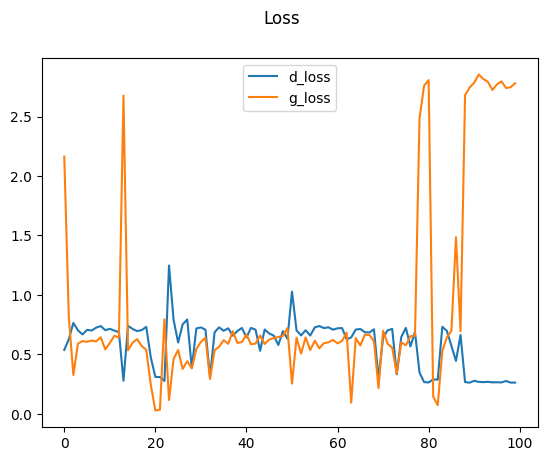

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()


# 5. Test Out the Generator

5.1 Generate Images

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 218ms/step


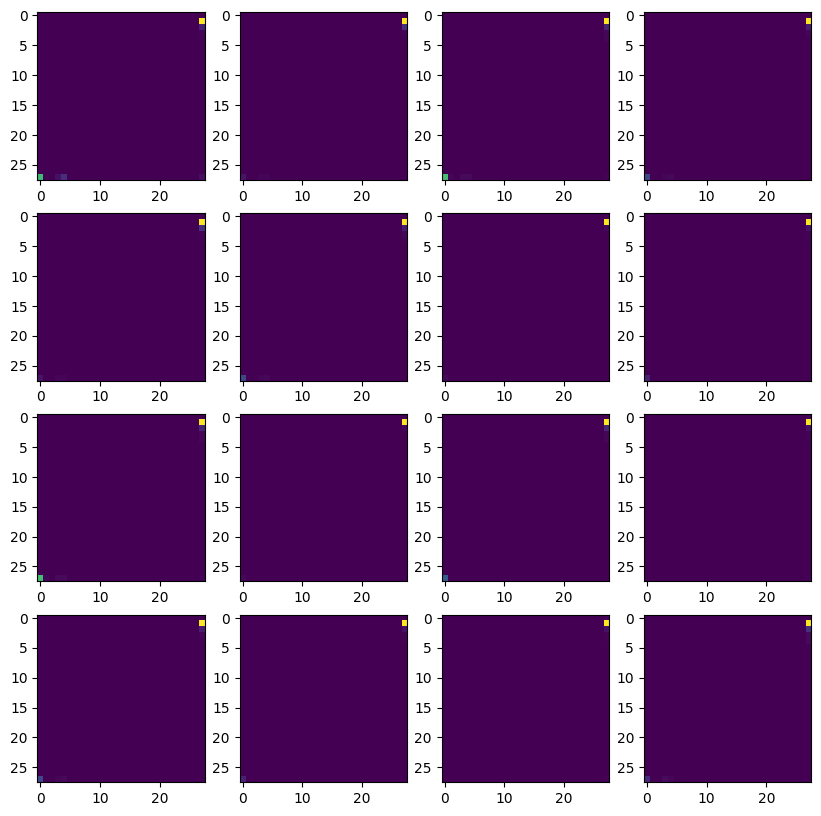

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')